In [1]:
! pip install langgraph 

In [2]:
! pip install langchain_community

In [3]:
! pip install langchain_huggingface

In [4]:
! pip install Chromadb

In [5]:
! pip install tavily

In [6]:
! pip install langchain

In [7]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated,Literal,Tuple,Optional
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
import requests
import os
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings



d:\Desktop\Agentic-Rag-Chatbot\envv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
load_dotenv()

True

In [9]:
class Agentstate(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]
    context:str
    


In [10]:
! pip install sentence-transformers

In [11]:
! pip install openai

In [12]:
import numpy as np


from langchain.tools import tool
from langchain_community.utilities import WikipediaAPIWrapper

@tool
def wikipedia_search(query: str) -> str:
    """Searches Wikipedia for a given topic and returns a short summary.
    
    Use this when the user asks about factual, historical, or conceptual information.
    """
    try:
        wiki = WikipediaAPIWrapper()
        result = wiki.run(query)
        if result:
            return result
        else:
            return f"No relevant Wikipedia content found for '{query}'."
    except Exception as e:
        return f"Error fetching Wikipedia data: {str(e)}"
    
#bmi api
@tool
def calculate_bmi(height:float,weight:float)->Tuple[float,str]:
    """
    Calculate the Body Mass Index (BMI) based on a person's height (in meters) and weight (in kilograms).
    Use this tool when a user asks about BMI, health category, or body weight status."""
    bmi=weight/(height**2)
    if bmi < 18.5:
        category = "Underweight"
    elif 18.5 <= bmi < 25:
        category = "Normal weight"
    elif 25 <= bmi < 30:
        category = "Overweight"
    else:
        category = "Obese"
    
    return bmi, category

search_tool=DuckDuckGoSearchRun(region="us-en")

@tool
def get_weather_update(symbol:str):
    """
    Fetch the current weather information for a specific city using the OpenWeather API.
    Use this tool when a user asks about the weather, temperature, or weather conditions in any location."""
    api_key=os.getenv("WEATHER_API_KEY")
    url=f"http://api.openweathermap.org/data/2.5/weather?q={symbol}&appid={api_key}&units=metric"
    try:
        response=requests.get(url)
        return response.json()
    except requests.exceptions.RequestException as e:
        return {"error":str(e)}
    

@tool
def get_conversion_factor(base_currency:str,target_currency:str,amount:str)->float:
    """
    Convert a specific amount from one currency to another using real-time exchange rates.
    Use this tool when a user asks to convert money between different currencies. """
    api_key=os.getenv("CURRENCY_CONVERSION_API_KEY")
    url=f"https://api.exchangerate.host/convert?from={base_currency}&to={target_currency}&amount={amount}&access_key={api_key}"
    response=requests.get(url)
    return response.json()


@tool
def get_stock(symbol:str)->str:
    """ Retrieve the latest intraday stock price and related information for a given company ticker symbol.
    Use this tool when a user asks for stock prices, share values, or stock market updates. """
    api_key=os.getenv("STOCK_API_KEY")
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&apikey={api_key}"
    response = requests.get(url)
    return response.json()
    

@tool
def calculator(a:int,b:int,operation:str)->float:
    """ Perform basic arithmetic operations such as addition, subtraction, multiplication, division, power, and square root.
    Use this tool when a user asks to perform a mathematical calculation."""
    if operation=="add":
        return a+b
    elif operation=="subtract":
        return a-b
    elif operation=="product":
        return a*b
    elif operation=="divide":
        return a/b
    elif operation=="power":
        return a**b
    elif operation=="sqrt":
        return np.sqrt(a)


In [13]:
llm1=HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b",temperature=0.7,task="text-generation",model_kwargs={"api_key":"HUGGINGFACEHUB_API_TOKEN"})
model=ChatHuggingFace(llm=llm1)

In [14]:
tools=[calculate_bmi,search_tool,get_weather_update,get_conversion_factor,get_stock,calculator,wikipedia_search]

In [15]:
llm_with_tool=model.bind_tools(tools)

In [16]:
Ai_message=llm_with_tool.invoke("What is Weather in Gurugram?")
Ai_message

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"symbol":"Gurugram"}', 'name': 'get_weather_update', 'description': None}, 'id': 'fc_09223353-ffd1-4afb-8227-21a601918f8f', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 477, 'total_tokens': 515}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--af3dcb7b-2bf0-4a8b-9a10-69c1ce49aa8d-0', tool_calls=[{'name': 'get_weather_update', 'args': {'symbol': 'Gurugram'}, 'id': 'fc_09223353-ffd1-4afb-8227-21a601918f8f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 477, 'output_tokens': 38, 'total_tokens': 515})

In [17]:
! pip install google-api-python-client

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [18]:
from googleapiclient.discovery import build

d:\Desktop\Agentic-Rag-Chatbot\envv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [19]:
! pip install bs4

In [20]:
from langchain_core.messages import ToolMessage

In [21]:

#Define node function
def chat_model(state: Agentstate):
    latest_msg = state["messages"][-1].content.lower()
    if any(word in latest_msg for word in ["explain", "describe","What is","information"]):
        # RAG will handle, don't generate yet
        return {"messages": state["messages"]}
    elif any(word in latest_msg for word in ["stock", "calculate", "weather", "news", "bmi", "conversion", "currency"]):
        # Tool will handle, don't generate yet
        response = llm_with_tool.invoke(latest_msg)
        state["tool_invoked"] = True  # Set the flag to True
        return {"messages": state["messages"] + [response]}
    else:
        # LLM can answer directly
        response = llm_with_tool.invoke(state["messages"])
        return {"messages": state["messages"] + [response]}



# Wrap the ToolNode in a callable function for your workflow
tool_node_instance = ToolNode(tools)

def generate_tool_response(state: Agentstate):
    # find the latest ToolMessage content

    tool_messages = [m for m in state["messages"] if isinstance(m, ToolMessage)]
    if not tool_messages:
        return {"messages": [AIMessage(content="No tool output found.")]}

    latest_tool_output = tool_messages[-1].content

    # Now use your llm to produce final answer
    response = llm_with_tool.invoke([
        HumanMessage(content=f"Give one line response to this tool result: {latest_tool_output}")
    ])
    return {"messages": [response]}

    
def rag_node(state: Agentstate):
    query=state["messages"][-1].content.strip()
    limit=3
    google_api_key = os.getenv("GOOGLE_API_KEY")
    cse_id = os.getenv("GOOGLE_CSE_ID") 
    if not google_api_key or not cse_id:
        raise RuntimeError("Please set Google APi Key in your environment.")
    
    try:
        service = build("customsearch", "v1", developerKey=google_api_key)
        response = service.cse().list(q=query,cx=cse_id,num=limit).execute()
        urls = [item.get("link") for item in response.get("items", [])][:limit]
    except Exception as e:
        print("Error retrieving URLs:", e)
        urls = []

    if not urls:
        return {"context": "No relevant information found.", "messages": state["messages"]}

    
    #Document loader  
    docs=[]
    for url in urls:
        loader=WebBaseLoader(url)
        docs.extend(loader.load())
        
    #Text-splitter
    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200)
    
    chunks=text_splitter.split_documents(docs)
    
    #embedding
    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    
    #vector_store
    vector_store=Chroma.from_documents(
        embedding=embedding,
        documents=chunks,
        collection_name="my_data"
    )
    retriver=vector_store.as_retriever(search_kwargs={"k":3},search_type="similarity")
    retrieved_docs=retriver.invoke(query)
    
    def format_docs(docs):
        return "\n".join(doc.page_content for doc in docs)
    
    context=format_docs(retrieved_docs)
    
    return {"context":context}

def generate_rag(state:Agentstate):
    query=state["messages"][-1].content
    context=state["context"]
    prompt=PromptTemplate(template=""" You are a Powerful assistant, Generate the final answer from the context {context} and provided question:{question} """,input_variables=["context","question"])
    model=llm_with_tool
    parser=StrOutputParser()
    
    chain=prompt|model|parser
    
    response=chain.invoke({"context":context,"question":query})
    
    return {"messages":[AIMessage(content=response)]}


def check_condition(state:Agentstate):
    latest_message = next(
        (m.content.lower() for m in reversed(state["messages"]) if isinstance(m, HumanMessage)),
        ""
    )
    rag_keywords = [
        "explain", "describe", "define", "tell me about", 
        "information", "details on", "who is", "history of", "when was", "why does"
    ]
    tool_keywords = [
        # BMI or calculation-related
        "bmi", "body mass", "calculate", "compute", "math", "sum", "add", "subtract", "divide", "multiply", "square root",
        # Currency or conversion
        "convert", "exchange rate", "currency", "usd", "inr", "euro", "dollar", 
        # Stocks
        "stock", "share", "price", "market", "equity",
        # Weather
        "weather", "temperature", "forecast", "climate",
        # AI news
        "news", "ai update", "ai news", "latest ai", "tech news", "technology"
    ]


    if any(kw in latest_message for kw in rag_keywords):
        print("Routing to RAG")
        return "rag_node"
    elif any(kw in latest_message for kw in tool_keywords):
        print("Routing to TOOL")
        return "tool_node"
    else:
        print("Routing to CHAT")
        return "END"
        
     

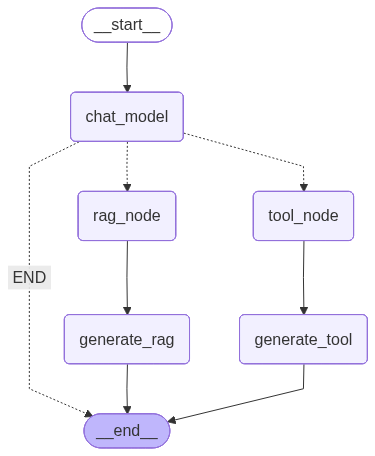

In [22]:
graph = StateGraph(Agentstate)
checkpointer=InMemorySaver()
graph.add_node("chat_model", chat_model)
graph.add_node("rag_node", rag_node)
graph.add_node("tool_node", tool_node_instance)
graph.add_node("generate_rag", generate_rag)
graph.add_node("generate_tool",generate_tool_response)

graph.add_edge(START, "chat_model")

graph.add_conditional_edges(
    "chat_model",
    check_condition,
    {
        "rag_node": "rag_node",
        "tool_node": "tool_node",
        "END": END,
    }
)

graph.add_edge("rag_node", "generate_rag")
graph.add_edge("tool_node", "generate_tool")
graph.add_edge("generate_rag", END)
graph.add_edge("chat_model",END)
graph.add_edge("generate_tool",END)

workflow = graph.compile(checkpointer=checkpointer)
workflow



In [23]:
thread_id="1"
initial_state={"messages":[HumanMessage(content="Describe Red fort attack in Delhi")]}
config={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config)
output["messages"]
output["messages"][-1].content


Routing to RAG


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


'**Red\u202fFort Attack – 22\u202fDecember\u202f2000**\n\n| Element | Details |\n|---------|---------|\n| **Date** | 22\u202fDecember\u202f2000 |\n| **Location** | Red\u202fFort, Delhi (India’s historic Mughal palace and a UNESCO World Heritage site) |\n| **Perpetrators** | Six operatives from the Pakistan‑based militant group *Lashkar‑e‑Taiba* (LeT) |\n| **Method** | The attackers stormed the fort, opening fire on security personnel and civilians inside. The assault was carried out in a single coordinated raid. |\n| **Casualties** | • 2 Indian soldiers killed<br>• 1 civilian (tourist/visitor) killed |\n| **Immediate Consequence** | The incident caused a temporary lockdown of the fort and heightened security for subsequent events, including the annual Independence Day celebrations. |\n| **Strategic Context** | The attack was widely reported as an attempt to sabotage the then‑ongoing India‑Pakistan peace talks. By striking a highly symbolic site, the attackers sought to create political

In [24]:
thread_id="3"
initial_state={"messages":[HumanMessage(content="Write a poem on pizza")]}
config={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config)
output["messages"][-1].content

Routing to CHAT


'**Ode to a Slice**\n\nIn the hush of midnight kitchens,  \nWhen ovens hum a quiet song,  \nA golden circle waits, patient,  \nFor the hand that’ll press it long.\n\nTomato sunrise drapes the crust,  \nA crimson tide that sings of earth;  \nBasil leaves, like emerald mist,  \nFloat upon the fragrant hearth.\n\nMozzarella clouds rise like clouds,  \nA creamy, molten, dream‑like veil,  \nEach bite a symphony unbound,  \nA tender, salty, savory tale.\n\nCheese and dough, in warm embrace,  \nWith pepperoni’s ruby kiss,  \nA swirl of pepper, oregano—  \nA culinary, aromatic bliss.\n\nFrom the first bite to the very last,  \nThe world dissolves in cheesy grace.  \nA simple plate, a humble crust,  \nYet the heart of comfort in each taste.\n\nSo raise a slice to midnight’s glow—  \nTo pizza, friend of every soul—  \nA slice of joy, a bite of love,  \nWrapped in dough and fragrant spice.'

In [25]:
thread_id="2"
initial_state={"messages":[HumanMessage(content="What is weather of Gurugram")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"][-1].content

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Routing to TOOL


'It’s a hazy day in Gurugram with a 21\u202f°C temperature, light winds at 2.6\u202fm/s, and 20\u202f% cloud cover.'

In [26]:
thread_id="2"
initial_state={"messages":[HumanMessage(content="What is stock price of Apple Company")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"][-1].content

Routing to TOOL


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


'Apple’s last intraday price on 28\u202fNov\u202f2025 at 16:55\u202f(US\u202fET) was $278.3702, trading within a 5‑minute range of $278.2000 to $278.5000.'

In [27]:
thread_id="4"
initial_state={"messages":[HumanMessage(content="add 123 and 234")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"]

Routing to TOOL


[HumanMessage(content='add 123 and 234', additional_kwargs={}, response_metadata={}, id='c4c92d6c-ab14-4e3b-8264-f75abbd048b0'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"a":123,"b":234,"operation":"addition"}', 'name': 'calculator', 'description': None}, 'id': 'fc_3ddcfb05-37c5-4b9a-ba02-ba7a5d9b90a8', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 475, 'total_tokens': 524}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_2b688e7cc3', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--627ef172-2549-42ed-aee7-ef7850763e31-0', tool_calls=[{'name': 'calculator', 'args': {'a': 123, 'b': 234, 'operation': 'addition'}, 'id': 'fc_3ddcfb05-37c5-4b9a-ba02-ba7a5d9b90a8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 475, 'output_tokens': 49, 'total_tokens': 524}),
 ToolMessage(content='null', name='calculator', id='01ef1962-91c5-4d7f-a964-5aa8003bc139', tool_call_i

In [28]:
thread_id="5"
initial_state={"messages":[HumanMessage(content="What is current Ai News")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Routing to TOOL


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[HumanMessage(content='What is current Ai News', additional_kwargs={}, response_metadata={}, id='477e9bda-24fe-488e-b141-a08dffb4a132'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query":"latest AI news"}', 'name': 'duckduckgo_search', 'description': None}, 'id': 'fc_2a4ffc7f-7244-406e-af61-dfd303706901', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 474, 'total_tokens': 539}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_63473661d7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--80341fe6-8be5-4e3b-83f5-f1ec31394846-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'latest AI news'}, 'id': 'fc_2a4ffc7f-7244-406e-af61-dfd303706901', 'type': 'tool_call'}], usage_metadata={'input_tokens': 474, 'output_tokens': 65, 'total_tokens': 539}),
 ToolMessage(content="Sep 19, 2025 · Hundreds of scientists, business leaders, faculty, and students shared the 

In [29]:
thread_id="6"
initial_state={"messages":[HumanMessage(content="Calculate the  BMI of height 19.2 and weight 50")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"][-1].content

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Routing to TOOL


'Your BMI is 13.56, indicating underweight status.'

In [30]:
list[workflow.get_state(config=config2)]

list[{'messages': [HumanMessage(content='Calculate the  BMI of height 19.2 and weight 50', additional_kwargs={}, response_metadata={}, id='2dca282c-6d46-44e4-80b5-c9ada699336f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"height":1.92,"weight":50}', 'name': 'calculate_bmi', 'description': None}, 'id': 'fc_c3acc9b0-fb2b-4e62-b679-20493374b7ae', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 194, 'prompt_tokens': 483, 'total_tokens': 677}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_d6de37e6be', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--819fb93b-50ed-4f1d-97f6-bfac3d85257d-0', tool_calls=[{'name': 'calculate_bmi', 'args': {'height': 1.92, 'weight': 50}, 'id': 'fc_c3acc9b0-fb2b-4e62-b679-20493374b7ae', 'type': 'tool_call'}], usage_metadata={'input_tokens': 483, 'output_tokens': 194, 'total_tokens': 677}), ToolMessage(content='[13.563368055555555, "Underweight"]', name='calculat

In [31]:
# workflow.get_state_history(config=config)

In [32]:
# When a tool is used, DO NOT expand, rewrite, or summarize the tool response.
# Just return the tool result EXACTLY as it is.

RAG Evaluation using RAGAS

In [39]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")


In [ ]:
from langsmith import Client
client=Client()